# Welcome to Lab 4

This is lab 4 of the reinforcement learning. In this lab, you will need to impliment the PPO algorithm, train the agent, and see it in action. Then you will need to write an report on your implimentation.

## Objective

The primary objective of this lab is to familiarize students with the PPO algorithm using basic deep learning libraries, enabling them to improve their capability in transfering mathmatical and theorical knowledge into python implimentation, and further their understanding in actor-critic algorithm.

## Requirements

To participate in this lab, students must have access to a Python programming environment. This canbesetuplocallyusingAnaconda. Alternatively, studentscanuseonlineplatformssuchasGoogle Colab, which provides a ready-to-use environment with access to Python and its libraries without any local setup.


# PPO (Proximal Policy Optimization)

Proximal Policy Optimization (PPO) is one of successful algorithms in today's reinforcement learning.

PPO is an algorithm that optimizes stochastic policy in on-policy way. However, in order to avoid the loss of performance, PPO algorithm prevents the update from stepping so far.<br>
To prevent large updates in PPO algorithm, there are two variants: PPO-Penalty and PPO-Clip. In this example, we'll focus on PPO-Penalty which is widely used in practical works.

> Note : The idea of PPO-Clip is more simple rather than PPO-Penalty. PPO-Clip limits the update by just clipping with $ \epsilon $.<br>
> For details about PPO-Clip, see [OpenAI document](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

The algorithm will learn policy parameters $ \theta $ with advantages $ A $.<br>
When we assume that the agent takes large advantage $ A $ on action $ a $, $ P(a | \pi_\theta (s)) $ must be increased much more than $ P(a | \pi_{\theta_{old}} (s)) $, with new parameters $ \theta $.<br>
Hence you can expect new $ \theta $ as follows to optimize policy. :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A \right] $$

In order to prevent large policy updates, PPO penaltizes for this expectation as follows :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|penalty| \right] $$

where $ \beta $ is the coefficient for the weight of penalty.

In PPO-Penalty, KL-divergence is used for this penalty term. :

$$ \verb|penalty| := \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) $$

Now I briefly explain about KL-divergence (Kullback-Leibler divergence).<br>
We assume that both $ P(x) $ and $ Q(x) $ are stochastic distributions. KL-divergence $\verb|KL|( P \| Q )$ is then defined as follows and often used in information theory, such as, approximate inference.

$$ \verb|KL|( P \| Q ) := -\int{P(x) \ln{\frac{Q(x)}{P(X)}}}dx $$

By this definition, $ \verb|KL|( P \| Q ) $ will be always positive or zero, and zero if and only if both distributions are same.<br>
This means that $ \verb|KL|( P \| Q ) $ indicates how far between these distributions, $ P $ and $ Q $. If $ Q $ is so far from $ P $, $ \verb|KL|( P \| Q ) $ will become largely positive.

> Note : For details about entropy and KL-divergence, see chapter 1.6 in "[Pattern Recognition and Machine Learning](http://wordpress.redirectingat.com/?id=725X1342&isjs=1&jv=15.1.0-stackpath&sref=https%3A%2F%2Ftsmatz.wordpress.com%2F2020%2F06%2F01%2Fsvm-and-kernel-functions-mathematics%2F&url=https%3A%2F%2Fwww.microsoft.com%2Fen-us%2Fresearch%2Fuploads%2Fprod%2F2006%2F01%2FBishop-Pattern-Recognition-and-Machine-Learning-2006.pdf&xguid=&xs=1&xtz=-540&xuuid=c861da822b99f831a421716ca3a51d33&xcust=8982&xjsf=other_click__auxclick%20%5B2%5D)" (Christopher M. Bishop, Microsoft).<br>
> KL-divergence is not symmetric, $ \verb|KL|( P \| Q ) \neq \verb|KL|( Q \| P ) $, and also $ arg\,min_Q \verb|KL|( P \| Q ) \neq arg\,min_Q \verb|KL|( Q \| P ) $ when $P$ is given.

Now go back to our equation. In order to penaltize for large update between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $, we look for the optimal parameters $ \theta $, such as :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) \right]  \;\;\;\;\; (1) $$

Even if the first term $ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A $ largely increases, new $ \theta $ might be rejected when the difference between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $ is so large.

Finally we optimize policy function by maximizing (1), and optimize value function by minimizing value loss. 

See [this paper](https://arxiv.org/pdf/1707.06347.pdf) for more details about PPO.


# Lab Instructions

## Part 1: Algorithm Implementation
### Task 1. **Set Up the Environment**
   - Just like before, we will be using the LunarLander environment.

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import time

ENV_NAME = 'LunarLander-v3'
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

### Task 2. **Understand the PPO Algorithm**
   - Review the theoretical foundations of PPO. (feel free to use any online resources, generative AI tools, etc...)
   - Understand the key components: policy network, value network, advantage estimation, and the actor-critic framework.

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99
LR_ACTOR = 0.0003
LR_CRITIC = 0.0003
MAX_EPISODES = 2000
PRINT_EVERY = 20
CLIP_RATIO = 0.2
ENTROPY_COEF = 0.01
VALUE_COEF = 0.5
EPOCHS = 10
BATCH_SIZE = 256
GAE_LAMBDA = 0.95
TIMESTEPS_PER_BATCH = 2048


class RunningMeanStd:
    def __init__(self, shape=(), epsilon=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.count += batch_count

    def normalize(self, x):
        return (x - self.mean) / np.sqrt(self.var + 1e-8)

class RolloutBuffer:
    def __init__(self):
        self.reset()

    def reset(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        self.returns = []
        self.advantages = []

    def add(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)

    def compute_returns_and_advantages(self, last_value, gamma, gae_lambda):
        returns = []
        advantages = []
        gae = 0

        for i in reversed(range(len(self.rewards))):
            if i == len(self.rewards) - 1:
                next_value = last_value
                next_non_terminal = 1.0 - self.dones[i]
            else:
                next_value = self.values[i + 1]
                next_non_terminal = 1.0 - self.dones[i]

            delta = self.rewards[i] + gamma * next_value * next_non_terminal - self.values[i]
            gae = delta + gamma * gae_lambda * next_non_terminal * gae

            returns.insert(0, gae + self.values[i])
            advantages.insert(0, gae)

        self.returns = returns
        self.advantages = advantages

        self.states = torch.FloatTensor(np.array(self.states)).to(DEVICE)
        self.actions = torch.LongTensor(np.array(self.actions)).to(DEVICE)
        self.log_probs = torch.FloatTensor(np.array(self.log_probs)).to(DEVICE)
        self.values = torch.FloatTensor(np.array(self.values)).to(DEVICE)
        self.returns = torch.FloatTensor(np.array(self.returns)).to(DEVICE)
        self.advantages = torch.FloatTensor(np.array(self.advantages)).to(DEVICE)

        self.advantages = (self.advantages - self.advantages.mean()) / (self.advantages.std() + 1e-8)

    def get_batches(self, batch_size):
        data_size = len(self.states)
        indices = np.random.permutation(data_size)

        for start_idx in range(0, data_size, batch_size):
            end_idx = min(start_idx + batch_size, data_size)
            batch_indices = indices[start_idx:end_idx]

            yield (
                self.states[batch_indices],
                self.actions[batch_indices],
                self.log_probs[batch_indices],
                self.returns[batch_indices],
                self.advantages[batch_indices],
                self.values[batch_indices]
            )

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

actor_net = Actor(obs_dim, n_actions).to(DEVICE)
critic_net = Critic(obs_dim).to(DEVICE)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=LR_ACTOR)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=LR_CRITIC)


### Task 3. **Implement the PPO Algorithm**
   - Create separate networks for the policy (actor) and value (critic).
   - Design the training loop, including:
     - Sampling trajectories from the environment.
     - Computing rewards and advantages.
     - Updating the policy and value networks using gradients.
   - Use appropriate hyperparameters (e.g., learning rates, number of steps, discount factor).

In [3]:
obs_rms = RunningMeanStd(shape=obs_dim)

def collect_batch_experiences():
    buffer = RolloutBuffer()
    total_steps = 0
    episode_rewards = []

    while total_steps < TIMESTEPS_PER_BATCH:
        obs, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Normalize state
            obs_norm = obs_rms.normalize(obs)
            state_tensor = torch.FloatTensor(obs_norm).to(DEVICE)

            # Get action and value
            with torch.no_grad():
                action_probs = actor_net(state_tensor)
                value = critic_net(state_tensor).item()

            # Sample action
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            # Execute environment step
            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Store experience
            buffer.add(
                obs_norm,
                action.item(),
                reward,
                value,
                log_prob.item(),
                done
            )

            # Update state and reward
            obs = next_obs
            episode_reward += reward
            total_steps += 1

            # If reached target steps, end immediately
            if total_steps >= TIMESTEPS_PER_BATCH:
                break

        # Update observation normalizer
        obs_rms.update(np.array([obs]))
        episode_rewards.append(episode_reward)

    # Collect final value for GAE calculation
    if not done:
        with torch.no_grad():
            last_obs_norm = obs_rms.normalize(obs)
            last_obs_tensor = torch.FloatTensor(last_obs_norm).to(DEVICE)
            last_value = critic_net(last_obs_tensor).item()
    else:
        last_value = 0.0

    # Compute returns and advantages
    buffer.compute_returns_and_advantages(last_value, GAMMA, GAE_LAMBDA)

    return buffer, np.mean(episode_rewards)

def update_networks(buffer):
    actor_losses = []
    critic_losses = []
    entropy_values = []
    approx_kls = []

    # Multiple training epochs
    for _ in range(EPOCHS):
        # Iterate through all mini-batches
        for states, actions, old_log_probs, returns, advantages, _ in buffer.get_batches(BATCH_SIZE):
            # Calculate new action probabilities and values
            action_probs = actor_net(states)
            values = critic_net(states).squeeze()

            # Create distribution and calculate new log probs
            dist = torch.distributions.Categorical(action_probs)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            # Calculate policy ratio
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Calculate clipped policy objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1.0 - CLIP_RATIO, 1.0 + CLIP_RATIO) * advantages
            actor_loss = -torch.min(surr1, surr2).mean() - ENTROPY_COEF * entropy

            # Calculate value function loss
            critic_loss = VALUE_COEF * ((values - returns) ** 2).mean()

            # Calculate approximate KL divergence for monitoring
            approx_kl = ((ratio - 1) - torch.log(ratio)).mean().item()
            approx_kls.append(approx_kl)

            # Optimize Actor network
            actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor_net.parameters(), 0.5)
            actor_optimizer.step()

            # Optimize Critic network
            critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic_net.parameters(), 0.5)
            critic_optimizer.step()

            # Record metrics
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            entropy_values.append(entropy.item())

    return np.mean(actor_losses), np.mean(critic_losses), np.mean(entropy_values), np.mean(approx_kls)

### Task 4. **Test Your Implementation**
   - Train your PPO agent on LunarLander-v2 environment.
   - Record metrics such as episode rewards and training loss.
   - If you want, try other implementations of PPO and compare with yours. (You may use stablebaselines for this)

Episode 20/2000 | Avg Reward: -109.02 | Actor Loss: -0.0255 | Critic Loss: 23.2467 | Entropy: 1.0462 | KL: 0.0089 | Time: 10.19s
Episode 40/2000 | Avg Reward: -29.21 | Actor Loss: -0.0252 | Critic Loss: 40.2208 | Entropy: 1.0015 | KL: 0.0126 | Time: 23.12s
Episode 60/2000 | Avg Reward: 2.90 | Actor Loss: -0.0198 | Critic Loss: 12.0523 | Entropy: 0.8132 | KL: 0.0096 | Time: 32.14s
Episode 80/2000 | Avg Reward: 30.30 | Actor Loss: -0.0158 | Critic Loss: 18.5537 | Entropy: 0.9946 | KL: 0.0103 | Time: 40.49s
Episode 100/2000 | Avg Reward: 45.25 | Actor Loss: -0.0106 | Critic Loss: 9.4981 | Entropy: 0.6881 | KL: 0.0110 | Time: 48.80s
Episode 120/2000 | Avg Reward: 104.49 | Actor Loss: -0.0171 | Critic Loss: 20.9233 | Entropy: 0.6476 | KL: 0.0161 | Time: 56.98s
Episode 140/2000 | Avg Reward: 142.86 | Actor Loss: -0.0138 | Critic Loss: 15.5868 | Entropy: 0.6135 | KL: 0.0138 | Time: 65.69s
Episode 160/2000 | Avg Reward: 178.78 | Actor Loss: -0.0122 | Critic Loss: 13.9123 | Entropy: 0.5507 | KL

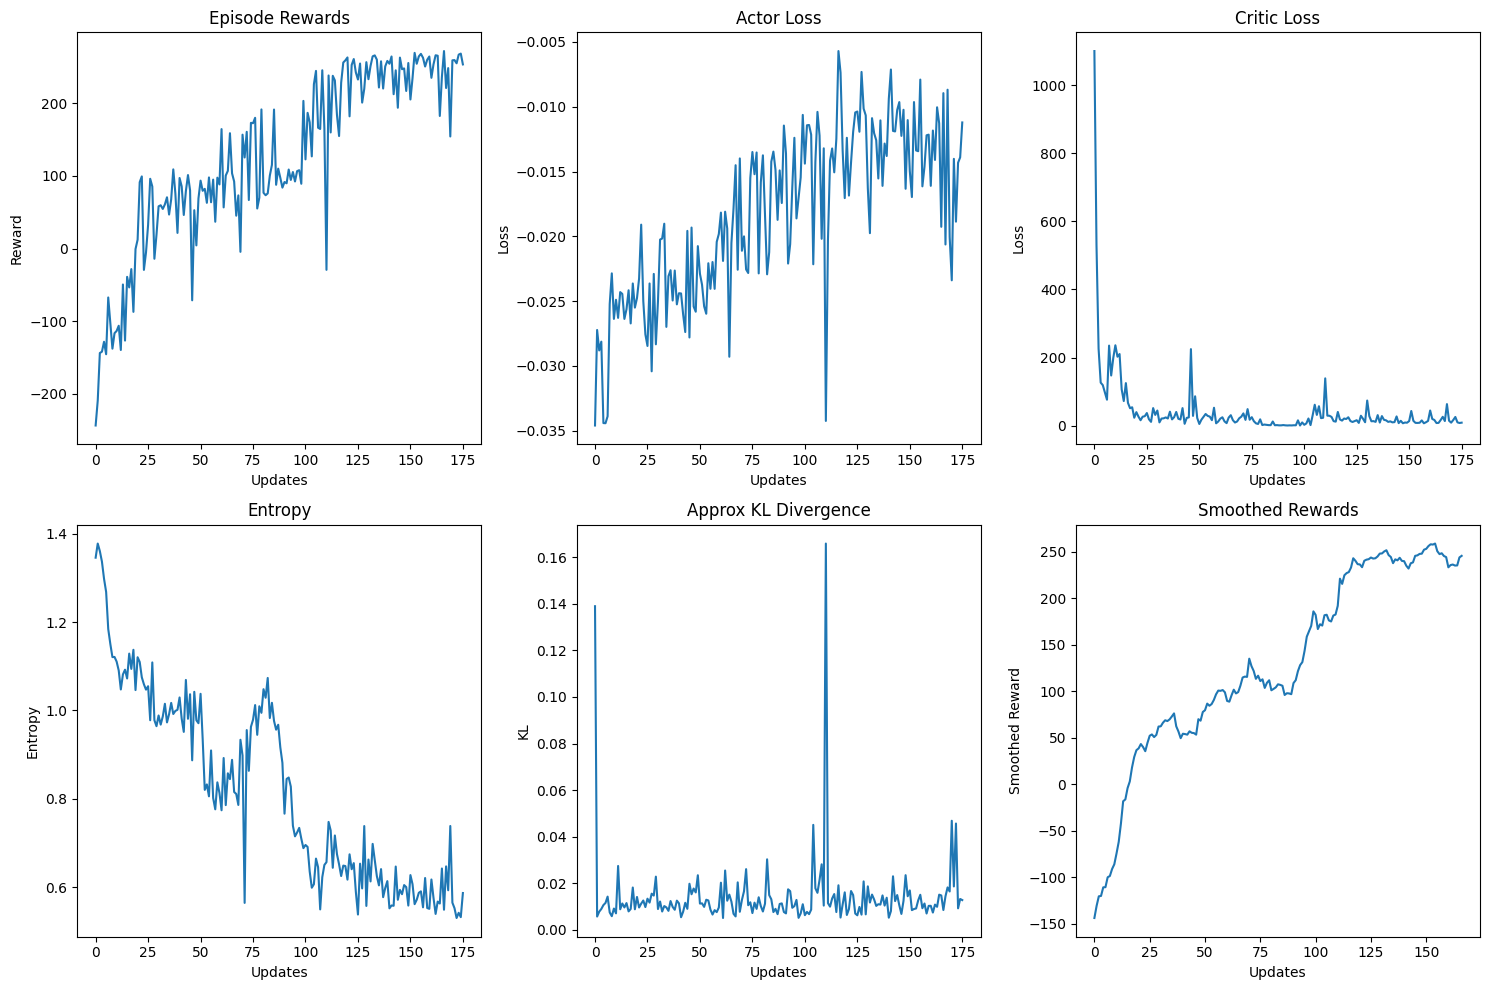

In [4]:
def train_ppo():
    training_rewards = []
    training_actor_losses = []
    training_critic_losses = []
    training_entropy_values = []
    training_kls = []

    avg_rewards = deque(maxlen=100)
    best_reward = -float('inf')

    start_time = time.time()

    for episode_num in range(1, MAX_EPISODES + 1):
        buffer, avg_episode_reward = collect_batch_experiences()
        actor_loss, critic_loss, entropy_value, approx_kl = update_networks(buffer)

        training_rewards.append(avg_episode_reward)
        training_actor_losses.append(actor_loss)
        training_critic_losses.append(critic_loss)
        training_entropy_values.append(entropy_value)
        training_kls.append(approx_kl)
        avg_rewards.append(avg_episode_reward)

        if episode_num % PRINT_EVERY == 0:
            avg_reward = np.mean(list(avg_rewards))
            elapsed_time = time.time() - start_time
            print(f"Episode {episode_num}/{MAX_EPISODES} | Avg Reward: {avg_reward:.2f} | Actor Loss: {actor_loss:.4f} | Critic Loss: {critic_loss:.4f} | Entropy: {entropy_value:.4f} | KL: {approx_kl:.4f} | Time: {elapsed_time:.2f}s")

        # Check if environment is solved
        if len(avg_rewards) == 100 and np.mean(list(avg_rewards)) >= 200:
            print(f"Environment solved in {episode_num} episodes! Average reward: {np.mean(list(avg_rewards)):.2f}")
            break

        current_avg_reward = np.mean(list(avg_rewards)) if len(avg_rewards) == 100 else avg_episode_reward
        if current_avg_reward > best_reward:
            best_reward = current_avg_reward
            torch.save({
                'actor': actor_net.state_dict(),
                'critic': critic_net.state_dict(),
                'obs_rms_mean': obs_rms.mean,
                'obs_rms_var': obs_rms.var,
            }, 'best_ppo_model.pt')

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(training_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Updates')
    plt.ylabel('Reward')

    plt.subplot(2, 3, 2)
    plt.plot(training_actor_losses)
    plt.title('Actor Loss')
    plt.xlabel('Updates')
    plt.ylabel('Loss')

    plt.subplot(2, 3, 3)
    plt.plot(training_critic_losses)
    plt.title('Critic Loss')
    plt.xlabel('Updates')
    plt.ylabel('Loss')

    plt.subplot(2, 3, 4)
    plt.plot(training_entropy_values)
    plt.title('Entropy')
    plt.xlabel('Updates')
    plt.ylabel('Entropy')

    plt.subplot(2, 3, 5)
    plt.plot(training_kls)
    plt.title('Approx KL Divergence')
    plt.xlabel('Updates')
    plt.ylabel('KL')

    if len(training_rewards) > 10:
        plt.subplot(2, 3, 6)
        window_size = min(10, len(training_rewards) // 10)
        smoothed_rewards = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_rewards)
        plt.title('Smoothed Rewards')
        plt.xlabel('Updates')
        plt.ylabel('Smoothed Reward')

    plt.tight_layout()
    plt.savefig('ppo_training_results.png')
    plt.show()

    return training_rewards, training_actor_losses, training_critic_losses, training_entropy_values

rewards, actor_losses, critic_losses, entropy_values = train_ppo()

In [5]:
def record_agent_video(env_name, actor_model, obs_normalizer, device, n_episodes=3):
    import gymnasium as gym
    from gymnasium.wrappers import RecordVideo
    import os

    os.makedirs("./videos", exist_ok=True)

    env_record = gym.make(env_name, render_mode="rgb_array")
    env_record = RecordVideo(env_record, video_folder="./videos",
                           episode_trigger=lambda x: True,
                           name_prefix="ppo-agent")

    for i in range(n_episodes):
        observation, _ = env_record.reset()
        episode_done = False
        total_reward = 0

        print(f"Recording episode {i+1}")

        while not episode_done:
            obs_norm = obs_normalizer.normalize(observation)
            state_tensor = torch.FloatTensor(obs_norm).to(device)

            with torch.no_grad():
                action_probs = actor_model(state_tensor)
            action = torch.argmax(action_probs).item()

            observation, reward, terminated, truncated, _ = env_record.step(action)
            episode_done = terminated or truncated
            total_reward += reward

        print(f"Episode {i+1} total reward: {total_reward:.2f}")

    env_record.close()
    print(f"Videos saved in ./videos directory")

record_agent_video(ENV_NAME, actor_net, obs_rms, DEVICE)

/Users/zr/Code/dts304/venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/zr/Code/dts304/dts307/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recording episode 1
Episode 1 total reward: 281.06
Recording episode 2
Episode 2 total reward: 255.39
Recording episode 3
Episode 3 total reward: 254.81
Videos saved in ./videos directory


### Part 2: Write an Report
Write a detailed lab Report covering the following:

1. **Introduction**
   - Briefly describe the A2C algorithm and its significance in reinforcement learning.
   - Mention the task/environment you chose for testing.

2. **Implementation Details**
   - Describe your implementation, including any challenges faced and how you addressed them.
   - Explain the structure of your policy and value networks.
   - Detail the training process and hyperparameters used.

3. **Results and Analysis**
   - Present your results (use graphs for better clarity).
   - Discuss the performance of your agent and any trends observed.
   - Compare your implementation with other implementation. (ie: stable-baselines)

4. **Reflections**
   - Reflect on your experience implementing PPO.
   - Discuss the improvement PPO made upon A2C.

5. **Conclusion**
   - Summarize key takeaways and insights from the lab.


# End of the Lab

Congratulations!! 🎉🎉🎉 You now reached the end of Lab 4!! 🎉🎉🎉

In this lab, you implemented the PPO algorithm, and completed your lab report, good job!!

Next week, we will try to have some old time fun and get you start on your last course work, best of luck and see you all next week!!
